In [31]:
import re
import unicodedata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [32]:
# 1. Carregar dados
url = "https://raw.githubusercontent.com/valdineyatilio/ProjetoAplicado-IV/main/A1/DadosDengueCSV.csv"
df = pd.read_csv(url)



In [33]:
# 2. Normalizar nomes para mapeamento (remove acentos, pontuação, espaços → underscores)
def normalize(col):
    s = unicodedata.normalize("NFD", col).encode("ascii", "ignore").decode("utf-8")
    s = re.sub(r"[^a-zA-Z0-9]", "_", s).lower()
    s = re.sub(r"_+", "_", s).strip("_")
    return s

orig_cols = df.columns.tolist()
norm_map  = { normalize(c): c for c in orig_cols }


In [34]:
# 3. Imprimir mapeamento normalizado → original para checagem
print("Colunas disponíveis (normalized -> original):")
for n,o in norm_map.items():
    print(f"  {n:30} -> {o}")


Colunas disponíveis (normalized -> original):
  data_inise                     -> data_iniSE
  se                             -> SE
  casos_est                      -> casos_est
  casos_est_min                  -> casos_est_min
  casos_est_max                  -> casos_est_max
  casos                          -> casos
  p_rt1                          -> p_rt1
  p_inc100k                      -> p_inc100k
  localidade_id                  -> Localidade_id
  nivel                          -> nivel
  id                             -> id
  versao_modelo                  -> versao_modelo
  tweet                          -> tweet
  rt                             -> Rt
  pop                            -> pop
  tempmin                        -> tempmin
  umidmax                        -> umidmax
  receptivo                      -> receptivo
  transmissao                    -> transmissao
  nivel_inc                      -> nivel_inc
  umidmed                        -> umidmed
  umidmin         

In [35]:
# 4. Detectar colunas de ano, semana e casos por substring
def find_key(subs):
    for n in norm_map:
        if any(sub in n for sub in subs):
            return norm_map[n]
    return None

col_year  = find_key(["ano", "year"])
col_week  = find_key(["semana", "week", "epi"])
col_cases = find_key(["cas", "case", "confirm"])



In [36]:

# 5. Verifica se as colunas existem
for col in (col_year, col_week, col_cases):
    if col not in df.columns:
        raise KeyError(f"Coluna '{col}' não encontrada. "
                       "Confira a lista impressa em df.columns e ajuste os nomes acima.")



KeyError: "Coluna 'None' não encontrada. Confira a lista impressa em df.columns e ajuste os nomes acima."

In [22]:
# 6. Converter para int e criar índice temporal ISO (primeiro dia da semana)
df[col_year]  = df[col_year].astype(int)
df[col_week]  = df[col_week].astype(int)

df["date"] = df.apply(lambda r: date.fromisocalendar(r[col_year], r[col_week], 1), axis=1)
df.set_index("date", inplace=True)
df.sort_index(inplace=True)


KeyError: None

In [23]:
# 7. Estatísticas descritivas e missing values
print("Estatísticas descritivas:")
print(df[[col_year,col_week,col_cases]].describe())
print("\nMissing values:")
print(df[[col_year,col_week,col_cases]].isnull().sum())


Estatísticas descritivas:


KeyError: '[None] not in index'

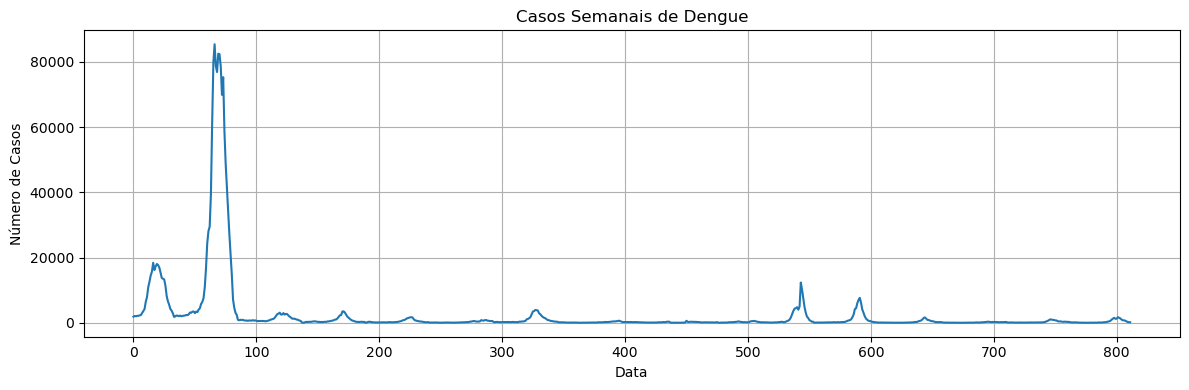

In [24]:
# 8. Série temporal de casos
plt.figure(figsize=(12,4))
plt.plot(df.index, df[col_cases], color="C0")
plt.title("Casos Semanais de Dengue")
plt.xlabel("Data")
plt.ylabel("Número de Casos")
plt.grid(True)
plt.tight_layout()
plt.show()



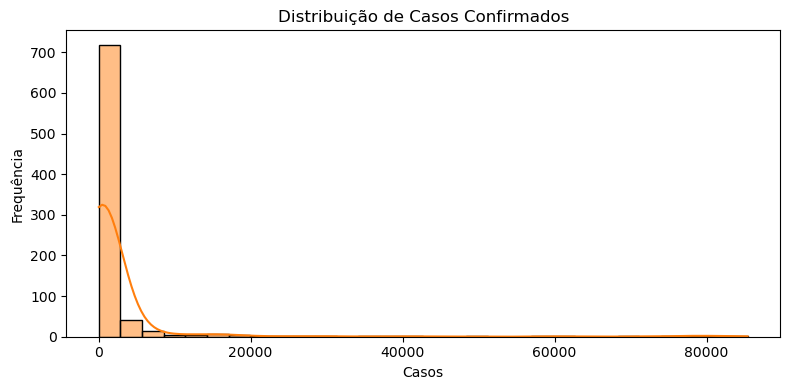

In [25]:
# 9. Distribuição dos casos
plt.figure(figsize=(8,4))
sns.histplot(df[col_cases], bins=30, kde=True, color="C1")
plt.title("Distribuição de Casos Confirmados")
plt.xlabel("Casos")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()


In [26]:
# 10. Boxplot anual
df["year"] = df.index.year
plt.figure(figsize=(10,4))
sns.boxplot(x="year", y=col_cases, data=df, palette="Blues")
plt.title("Boxplot Anual de Casos")
plt.xlabel("Ano")
plt.ylabel("Casos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



AttributeError: 'RangeIndex' object has no attribute 'year'

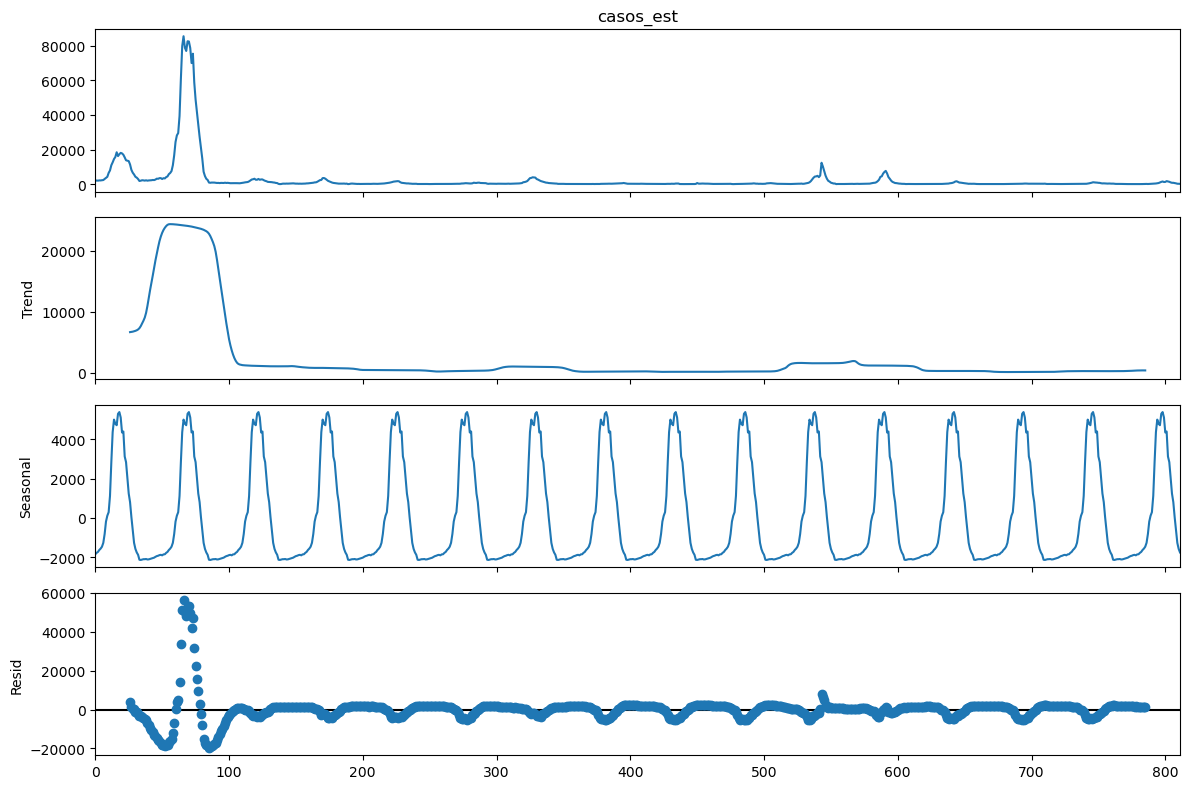

In [27]:
# 11. Decomposição aditiva
decomp = seasonal_decompose(df[col_cases], model="additive", period=52)
fig = decomp.plot()
fig.set_size_inches(12,8)
plt.tight_layout()
plt.show()



<Figure size 1200x300 with 0 Axes>

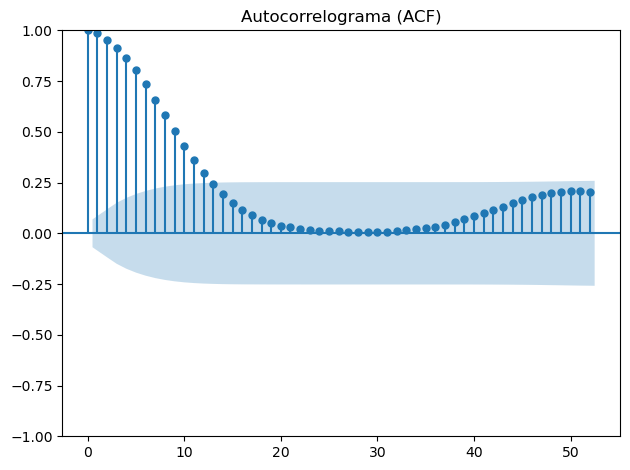

<Figure size 1200x300 with 0 Axes>

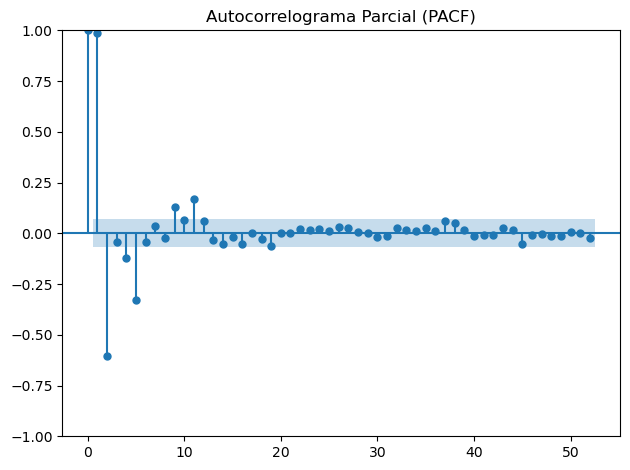

In [30]:
# 12. ACF e PACF
plt.figure(figsize=(12,3))
plot_acf(df[col_cases].dropna(), lags=52, alpha=0.05)
plt.title("Autocorrelograma (ACF)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,3))
plot_pacf(df[col_cases].dropna(), lags=52, alpha=0.05, method="ywm")
plt.title("Autocorrelograma Parcial (PACF)")
plt.tight_layout()
plt.show()
